In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import torch, torch.nn as nn, torch.nn.functional as F
from torch import tensor
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy
from torch.optim import lr_scheduler
import fastcore.all as fc
from functools import partial
from torchsummary import summary

from miniai.data import *
from miniai.learner import TrainLearner, MomentumLearner
from miniai.hooks import *
from miniai.custom_modules import conv, GeneralReLU
from miniai.callbacks import *

In [2]:
data = pd.read_csv('data/fashion_mnist/train.csv')

In [3]:
X_train = (tensor(data.iloc[:50000, 1:].values)/255.).view(-1, 1, 28, 28)
y_train = tensor(data.iloc[:50000, 0].values)
X_valid = (tensor(data.iloc[50000:, 1:].values)/255.).view(-1, 1, 28, 28)
y_valid = tensor(data.iloc[50000:, 0].values)

In [4]:
class FashionDataset(Dataset):
    def __init__(self, x, y, mean=None, std=None):
        self.mean = mean; self.std = std
        if self.mean is None: self.mean = x.mean()
        if self.std is None: self.std = x.std()
        self.x = (x - self.mean) / self.std
        self.y = y

In [5]:
dset_train = FashionDataset(X_train, y_train)
dset_valid = FashionDataset(X_valid, y_valid, dset_train.mean, dset_train.std)

In [6]:
dl_train = DataLoader(dset_train, batch_size=128, shuffle=True, num_workers=4)
dl_valid = DataLoader(dset_valid, batch_size=len(dset_valid), shuffle=False,  num_workers=4)

In [7]:
dls = DataLoaders(dl_train, dl_valid)

In [8]:
X_b, y_b = next(iter(dls.train))

<br>**Model**

In [9]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight, a=leaky)

In [10]:
class ResBlock(nn.Module):
    def __init__(self, in_f, out_f, ks=3, stride=2, act=None, norm=None):
        super(ResBlock, self).__init__()
        self.conv1 = conv(in_f, out_f, ks, stride=1, act=act, norm=norm)
        self.conv2 = conv(out_f, out_f, ks, stride=stride, norm=norm)
        self.conv_id = fc.noop if in_f==out_f else conv(in_f, out_f, ks=1, stride=1)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(kernel_size=stride, ceil_mode=True)
        self.act = act
        
    def forward(self, X):
        res = self.act(self.conv2(self.conv1(X)) + self.pool(self.conv_id(X)))
        return res

In [11]:
act_func = GeneralReLU(0.4, leaky=0.1)

model = nn.Sequential(
    ResBlock(1, 16, ks=5, stride=1, act=act_func, norm=nn.BatchNorm2d), #28
    ResBlock(16, 32, act=act_func, norm=nn.BatchNorm2d), #14
    ResBlock(32, 64, act=act_func, norm=nn.BatchNorm2d), #7
    ResBlock(64, 128, act=act_func, norm=nn.BatchNorm2d), #4
    ResBlock(128, 256, act=act_func, norm=nn.BatchNorm2d), #2
    ResBlock(256, 512, act=act_func, norm=nn.BatchNorm2d), #1
    nn.Flatten(),
    nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)
).apply(partial(init_weights, leaky=0.1))

In [71]:
total_params = 0
def _print_summary(hook, mod, inp, out):
    param_cnt = 0
    for p in mod.parameters():
        param_cnt += torch.prod(tensor(p.shape)).item()
    print(f'{type(mod).__name__:14} {str(list(inp[0].shape)):20} {str(list(out[0].shape)):16} {param_cnt}')
    global total_params; total_params += param_cnt
    
def get_summary(model):
    global total_params
    total_params = 0
    with Hooks(list(model), _print_summary): model(X_b)
    print(f'Total params:  {total_params}')

In [72]:
get_summary(model)

ResBlock       [128, 1, 28, 28]     [16, 28, 28]     6928
ResBlock       [128, 16, 28, 28]    [32, 14, 14]     14560
ResBlock       [128, 32, 14, 14]    [64, 7, 7]       57792
ResBlock       [128, 64, 7, 7]      [128, 4, 4]      230272
ResBlock       [128, 128, 4, 4]     [256, 2, 2]      919296
ResBlock       [128, 256, 2, 2]     [512, 1, 1]      3673600
Flatten        [128, 512, 1, 1]     [512]            0
Linear         [128, 512]           [10]             5120
BatchNorm1d    [128, 10]            [10]             20
Total params:  4907588


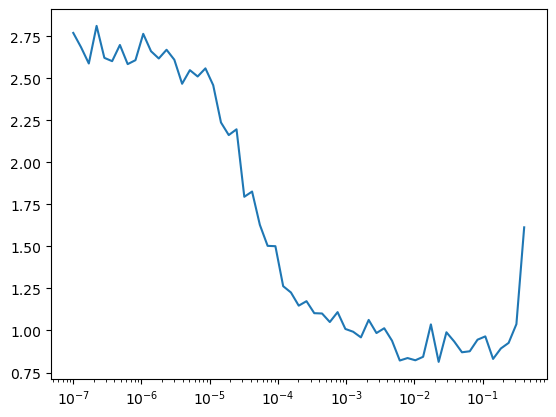

In [41]:
lr_finder = LRFinderCB()
learn = TrainLearner(dls, model, F.cross_entropy, cbs=[lr_finder, MetricCB(), ProgressCB()])
learn.fit(1, 1e-7)
lr_finder.plot()

In [47]:
epochs = 3
sched = partial(lr_scheduler.OneCycleLR, max_lr=6e-2, total_steps=epochs*len(dls.train)); schedCB = BatchSchedCB(sched)

learn = TrainLearner(dls, model, F.cross_entropy, cbs=[MetricCB(accuracy=MulticlassAccuracy()), ProgressCB(), schedCB])

In [48]:
with Hooks(model, append_stats) as hooks: learn.fit(epochs, 1e-2)

epoch,train_loss,valid_loss,accuracy
0,0.52,0.576,0.786
1,0.322,0.316,0.888
2,0.224,0.204,0.927


In [61]:
model[:-4]

Sequential(
  (0): ResBlock(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): GeneralReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_id): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
    (act): GeneralReLU()
  )
  (1): ResBlock(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): GeneralReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_id): Conv2d(8

In [67]:
model[-4]

ResBlock(
  (conv1): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GeneralReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_id): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (act): GeneralReLU()
)

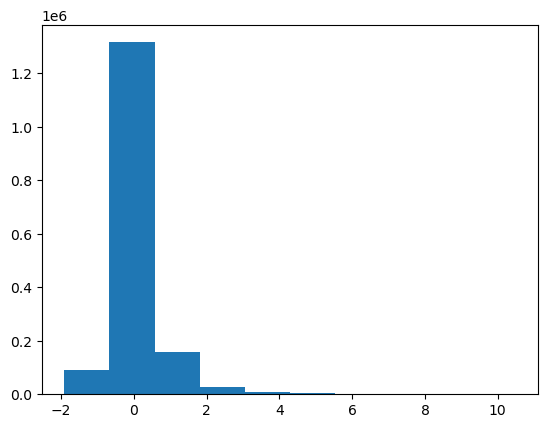

In [62]:
with torch.no_grad():
    plt.hist(model[:2](X_b).detach().view(-1))

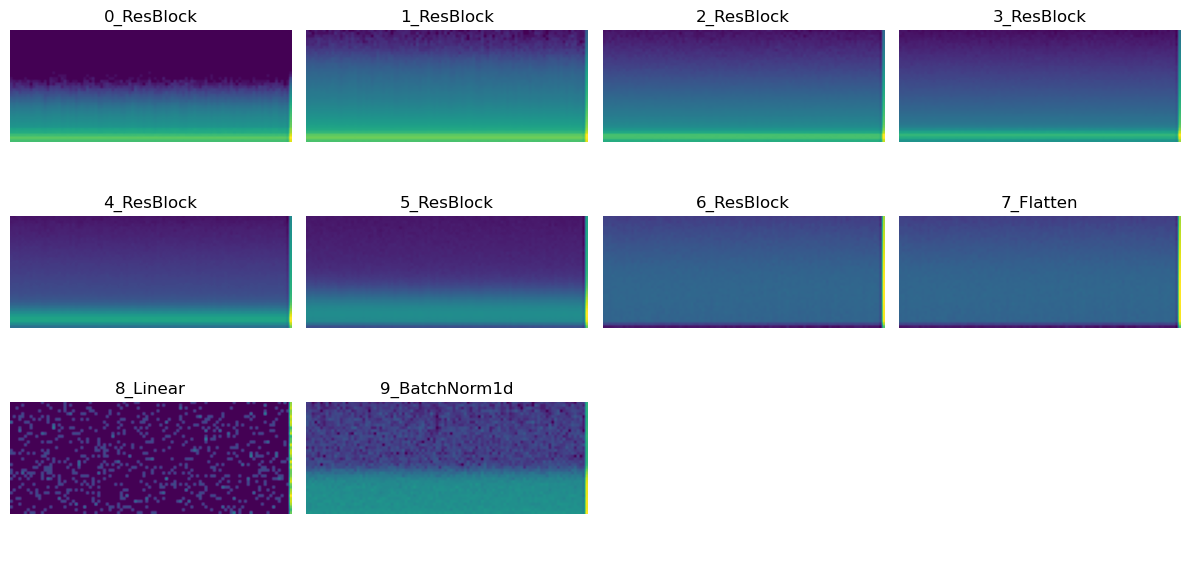

In [49]:
hooks.plot_acts(rng=[-100, None])

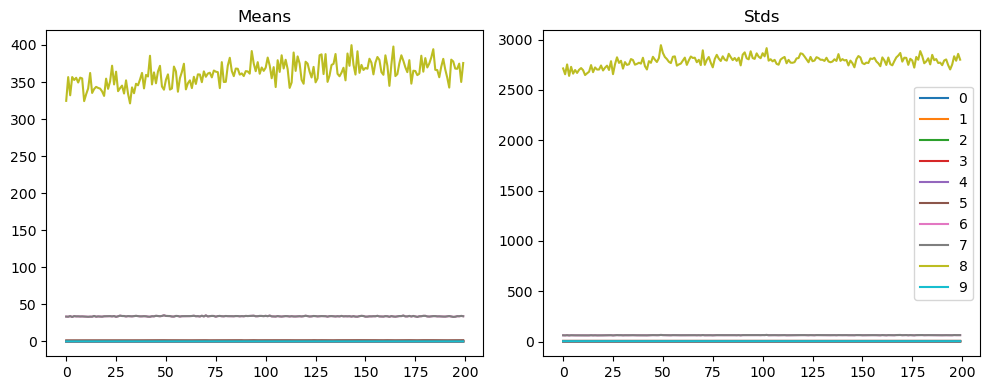

In [51]:
hooks.plot_means_stds([-200, None])